Thực hành 5: xác định đối tượng trong ảnh

2. Viết chương trình gán nhãn ảnh

2.1 Gán nhãn ảnh

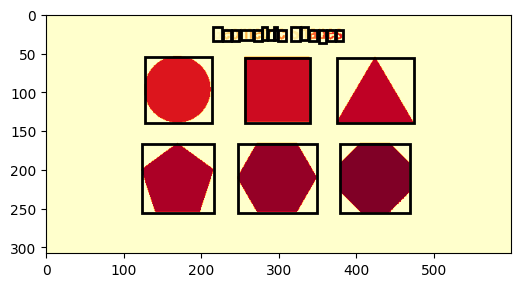

In [30]:
from PIL import Image
import numpy as np
import imageio.v2 as iio
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu
data = Image.open('geometric.png').convert('L')
a = np.asarray(data)
thres = threshold_otsu(a)
b = a > thres
c = label(b)
c1 = Image.fromarray((c * 255 / c.max()).astype(np.uint8))
iio.imsave('label_output.jpg', c1)
properties = ['Area', 'Centroid', 'BoundingBox']
d = regionprops(c)
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(c, cmap='YlOrRd')
for i in d:
    lr, lc, ur, uc = i['BoundingBox']
    rec_width = uc - lc
    rec_height = ur - lr
    rect = mpatches.Rectangle((lc, lr), rec_width, rec_height,
                              fill=False, edgecolor='black', linewidth=2)
    ax.add_patch(rect)

plt.show()


2.2 Dò tìm cạnh theo chiều dọc

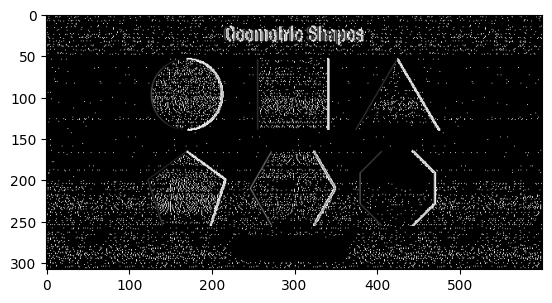

In [31]:
from PIL import Image
import numpy as np
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu
data = Image.open('geometric.png').convert('L')
a = np.asarray(data)
bmg = abs(a - nd.shift(a, (0, 1), order=0))
plt.imshow(bmg, cmap='gray')
plt.show()


2.3 Dò tìm cạnh với Sobel Filter

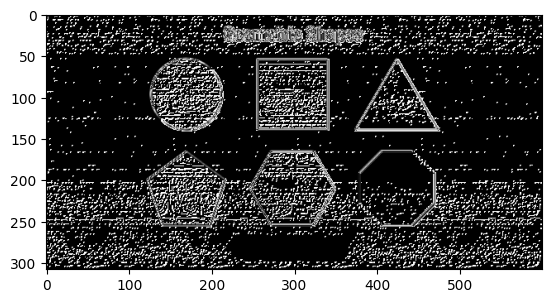

In [15]:
from PIL import Image
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

data = Image.open('geometric.png').convert('L')
a = np.asarray(data)
gx = nd.sobel(a, axis=0)  
gy = nd.sobel(a, axis=1)  
bmg = np.abs(gx) + np.abs(gy)
plt.imshow(bmg, cmap='gray')
plt.show()


2.4 Xác định góc của đối tượng

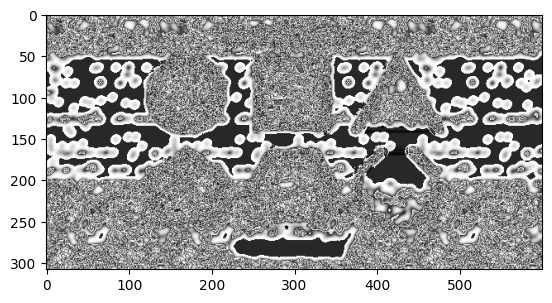

In [ ]:
from PIL import Image
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu


def Harris(indata, alpha=0.2):
    x = nd.sobel(indata, 0)  
    y = nd.sobel(indata, 1)  
    x1 = x ** 2
    y1 = y ** 2
    xy = x * y

    x1 = nd.gaussian_filter(x1, 3)
    y1 = nd.gaussian_filter(y1, 3)
    xy = nd.gaussian_filter(xy, 3)

    detC = x1 * y1 - xy**2
    trC = x1 + y1
    R = detC - alpha * (trC**2)

    return R
data = Image.open('geometric.png').convert('L')
data_array = np.array(data)
bmg = Harris(data_array)
plt.imshow(bmg, cmap='gray')
plt.show()


2.5 Dò tìm hình dạng cụ thể trong ảnh với Hough Transform

2.5.1 Dò tìm đường thẳng trong ảnh

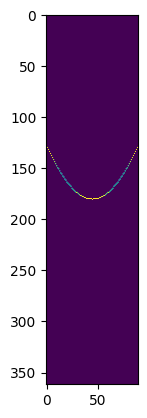

In [25]:
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

def LineHough(data, gamma):
    V, H = data.shape
    R = int(np.sqrt(V * V + H * H))
    ho = np.zeros((R, 90), float)  
    w = data + 0
    ok = 1
    theta = np.arange(90) / 180.0 * np.pi
    tp = np.arange(90).astype(float)

    while ok:
        mx = w.max()
        if mx < gamma:
            ok = 0
        else:
            v, h = divmod(w.argmax(), H)
            y = V - v
            x = h
            rh = x * np.cos(theta) + y * np.sin(theta)
            for i in range(len(rh)):
                if 0 <= rh[i] < R and 0 <= tp[i] < 90:
                    ho[int(rh[i]), int(tp[i])] += mx
            w[v, h] = 0
    return ho
data = np.zeros((256, 256))
data[128, 128] = 1

bmg = LineHough(data, 0.5)
plt.imshow(bmg)
plt.show()


2.5.2 Dò tìm đường tròn trong ảnh

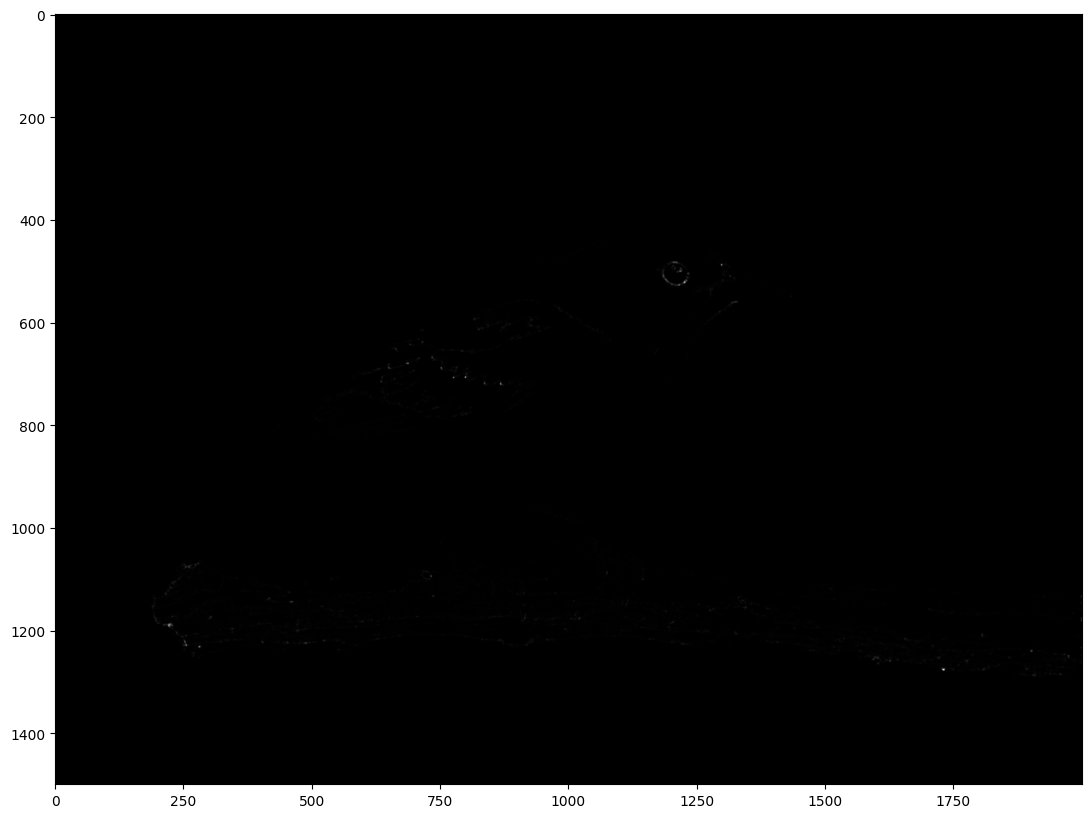

In [1]:
from PIL import Image
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.feature import corner_harris
from skimage.color import rgb2gray
data = iio.imread('bird.png')
image_gray = rgb2gray(data)
coordinate = corner_harris(image_gray, k=0.001)

plt.figure(figsize=(20, 10))
plt.imshow(coordinate, cmap='gray')  
plt.show()


2.6 Image matching

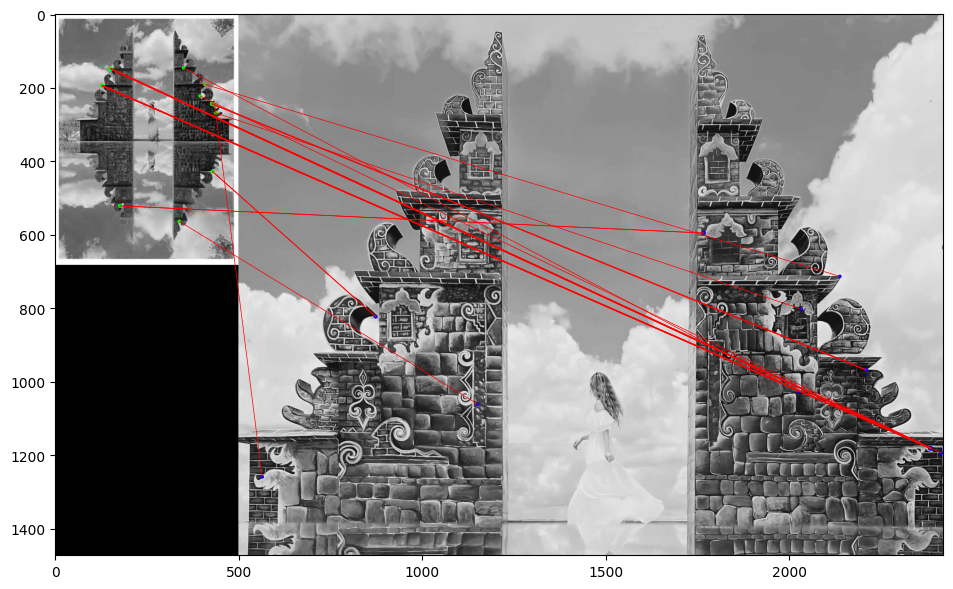

In [2]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.morphology import label
from skimage.measure import regionprops

def harris_corners(img_gray, threshold=0.01):
    img_float = np.float32(img_gray)
    dst = cv2.cornerHarris(img_float, blockSize=2, ksize=3, k=0.04)
    dst = cv2.dilate(dst, None)
    points = np.argwhere(dst > threshold * dst.max())
    return [tuple(p[::-1]) for p in points]  

def get_patch(img, point, patch_size=11):
    x, y = point
    r = patch_size // 2
    if x - r < 0 or y - r < 0 or x + r >= img.shape[1] or y + r >= img.shape[0]:
        return None
    return img[y - r:y + r + 1, x - r:x + r + 1]

def compute_descriptors(img_gray, keypoints, patch_size=11):
    descriptors = []
    valid_pts = []
    for pt in keypoints:
        patch = get_patch(img_gray, pt, patch_size)
        if patch is not None:
            desc = patch.flatten().astype(np.float32)
            desc = (desc - np.mean(desc)) / (np.std(desc) + 1e-8)
            descriptors.append(desc)
            valid_pts.append(pt)
    return valid_pts, descriptors

def match_descriptors_ratio_test(desc1, pts1, desc2, pts2, ratio=0.75):
    matches = []
    desc2 = np.array(desc2)
    for i, d1 in enumerate(desc1):
        dists = np.linalg.norm(desc2 - d1, axis=1)
        if len(dists) < 2:
            continue
        idx = np.argsort(dists)
        best, second = dists[idx[0]], dists[idx[1]]
        if best / (second + 1e-8) < ratio:
            matches.append((pts1[i], pts2[idx[0]]))
    return matches


def draw_matches_gray(img1_gray, img2_gray, matches):
    h1, w1 = img1_gray.shape
    h2, w2 = img2_gray.shape
    canvas = np.zeros((max(h1, h2), w1 + w2), dtype=np.uint8)
    canvas[:h1, :w1] = img1_gray
    canvas[:h2, w1:] = img2_gray

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(canvas, cmap='gray')
    for (x1, y1), (x2, y2) in matches:
        ax.plot([x1, x2 + w1], [y1, y2], 'r-', linewidth=0.5)
        ax.add_patch(mpatches.Circle((x1, y1), radius=3, color='lime', fill=True))
        ax.add_patch(mpatches.Circle((x2 + w1, y2), radius=3, color='blue', fill=True))


    plt.tight_layout()
    plt.show()


if __name__ == '__main__':

    img1_gray = np.array(Image.open('bali_1.jpg').convert('L'))
    img2_gray = np.array(Image.open('cong-troi-bali-da-lat.jpg').convert('L'))
    kp1 = harris_corners(img1_gray)
    kp2 = harris_corners(img2_gray)
    kp1, desc1 = compute_descriptors(img1_gray, kp1)
    kp2, desc2 = compute_descriptors(img2_gray, kp2)
    matches = match_descriptors_ratio_test(desc1, kp1, desc2, kp2)
    draw_matches_gray(img1_gray, img2_gray, matches)
